# Pytorch CNN - Brain Tumor Detection
# https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from glob import glob

import sklearn
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

%matplotlib inline

In [ ]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Use Cuda")
else:
    device = torch.device('cpu')
    print("Use CPU")

# Upload data zip file

* kaggle에서 바로 불러오기\
{"username": "계정이름", "key":"캐글 API key"}\
참고 : https://teddylee777.github.io/kaggle/Kaggle-API-%EC%82%AC%EC%9A%A9%EB%B2%95

In [ ]:
!echo '{"username":" ","key":" "}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip /content/brain-mri-images-for-brain-tumor-detection.zip -d archive

In [ ]:
file_dir = '여기에 <brain-tumor-dataset> 폴더의 경로를 복사 붙여넣기 해주세요'

* google drive 와 colab을 연결해 drive내의 알집 파일을 받아오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# archive.zip 의 경로를 입력하세요.
# ex) !unzip /content/drive/MyDrive/ESC/archive.zip
!unzip /content/archive.zip

In [ ]:
file_dir = '여기에 <brain-tumor-dataset> 폴더의 경로를 복사 붙여넣기 해주세요'

* local folder에서 colab으로 파일 불러오기

In [ ]:
from google.colab import files
# archive.zip 을 선택하면 됩니다.
files_upload = files.upload()

In [ ]:
!unzip /archive.zip

In [ ]:
file_dir = '여기에 <brain-tumor-dataset> 폴더의 경로를 복사 붙여넣기 해주세요'

# 1. Load data and preprocessing

* 이미지 파일 형식 및 차원 확인

In [ ]:
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(img, np.asarray(img).shape)

<PIL.Image.Image image mode=RGB size=260x331 at 0x7FC6CB51E150> (331, 260, 3)
<PIL.Image.Image image mode=RGB size=300x359 at 0x7FC6CB4B01D0> (359, 300, 3)
<PIL.Image.Image image mode=RGB size=911x938 at 0x7FC6CB4B06D0> (938, 911, 3)
<PIL.Image.Image image mode=RGB size=628x630 at 0x7FC6CB51E690> (630, 628, 3)
<PIL.Image.Image image mode=RGB size=289x300 at 0x7FC6CB51EAD0> (300, 289, 3)


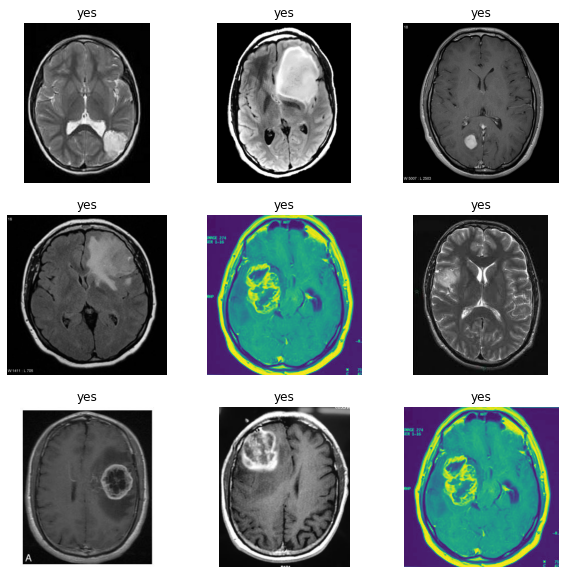

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  img = path[i]
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img))
  plt.title(os.path.split(os.path.split(img)[0])[-1])
  plt.axis("off")

* 데이터 로드 클래스 (변경하지 마세요!)

In [ ]:
# Do not change this class !!
class BrainMRIDataset(Dataset):

    def __init__(self, file_dir, transform):
      self.dataDirectory = file_dir
      self.transform = transform

      self.no_class = glob(file_dir+'/no/*')
      self.yes_class = glob(file_dir+'/yes/*')
      self.file_list = self.no_class + self.yes_class
      self.label_list = [0]*len(self.no_class) + [1]*len(self.yes_class)
      self.dataframe = pd.DataFrame({'image': self.file_list,
                                     'label': self.label_list})  
      self.dataframe = shuffle(self.dataframe)
      self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
      return len(self.no_class)+len(self.yes_class)

    def __getitem__(self, index):
      img_path = self.dataframe['image'][index]
      labels = self.dataframe['label'][index]
      labels = labels.tolist()
      
      if type(img_path) == str:
        img_path = [img_path]

      img_array = []
      for image in img_path:
        img = Image.open(image).convert("RGB")
        img_transformed = self.transform(img)
        array = np.asarray(img_transformed)
        img_array.append(array)
            
      return [torch.tensor(img_array, device=device),torch.tensor(labels, device=device)]
    
    def __repr__(self):
      print("Data loading succeed!!")
      print("-"*100)
      plt.figure(figsize=(10, 10))
      for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(self.file_list[i]))
        plt.title(os.path.split(os.path.split(self.file_list[i])[0])[-1])
        plt.axis("off")

      rep = pd.DataFrame({'File Path' : self.file_list})
      return str(rep.head(9))

# customize your transformation

In [ ]:
# you can add other 'torcivision.transforms.'
data_transform = transforms.Compose([
                                     # add transforms
                                     transforms.Resize((128,128)), # do not change resize!!
                                     transforms.ToTensor(),        # do not change totensor!!
                                     ])

In [ ]:
# data_transform 을 정의하고, 밑의 코드의 결과값이 모두 (3,128,128)이 나오는지 확인하세요.
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(np.asarray(data_transform(img)).shape)

(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


Data loading succeed!!
----------------------------------------------------------------------------------------------------


                                    File Path
0    /content/brain_tumor_dataset/no/8 no.jpg
1   /content/brain_tumor_dataset/no/15 no.jpg
2   /content/brain_tumor_dataset/no/2 no.jpeg
3   /content/brain_tumor_dataset/no/13 no.jpg
4  /content/brain_tumor_dataset/no/no 923.jpg
5      /content/brain_tumor_dataset/no/N3.jpg
6   /content/brain_tumor_dataset/no/no 97.jpg
7   /content/brain_tumor_dataset/no/40 no.jpg
8   /content/brain_tumor_dataset/no/no 96.jpg

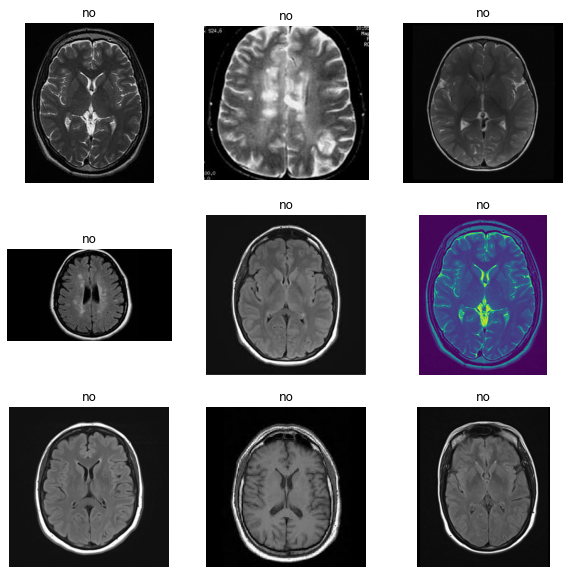

In [ ]:
# load the data
dataset = BrainMRIDataset(file_dir, transform = data_transform)
dataset

# 2. Modeing

In [ ]:
# can change, but remind the dimension
# First input must be : [1, 3, 128, 128]
# Last output must be : [1, 2]

class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # input : [1, 3, 128, 128]
            nn.Conv2d(3,256,kernel_size=3),     # output : ??
            nn.MaxPool2d(2,2),                  # output : ??
            nn.Conv2d(256,32,kernel_size=2)     # output : ??
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        # input : [1, 3, 128, 128]
        x = F.relu(self.conv1(x))       # output : ??
        x = F.relu(self.linear1(x))     # output : ??
        x = self.linear2(x)             # output : ??
        x = self.flat(x)                # output : ??
        x = self.linear3(x)             # output : [1, 2]

        return x

In [ ]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

# 3. Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# divide dataset to train and test.
train, test = random_split(dataset, [200, 53],generator=torch.Generator().manual_seed(42))
print("Total number of dataset:",len(dataset))
print("Train dataset:",len(train))
print("Test dataset:",len(test)) 

Total number of dataset: 253
Train dataset: 200
Test dataset: 53


In [ ]:
epochs = 100
batch_size = 8
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(train)//batch_size):
    
        data, target = train[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target.long())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 2.605238914489746
Epochs: 10 Loss: 0.039890188723802567
Epochs: 20 Loss: 0.0003682915703393519
Epochs: 30 Loss: 0.00015518978761974722
Epochs: 40 Loss: 9.199883788824081e-05
Epochs: 50 Loss: 6.151827255962417e-05
Epochs: 60 Loss: 4.384595376905054e-05
Epochs: 70 Loss: 3.261622623540461e-05
Epochs: 80 Loss: 2.4996195861604065e-05
Epochs: 90 Loss: 1.9636194338090718e-05


# 4. Visualize the result

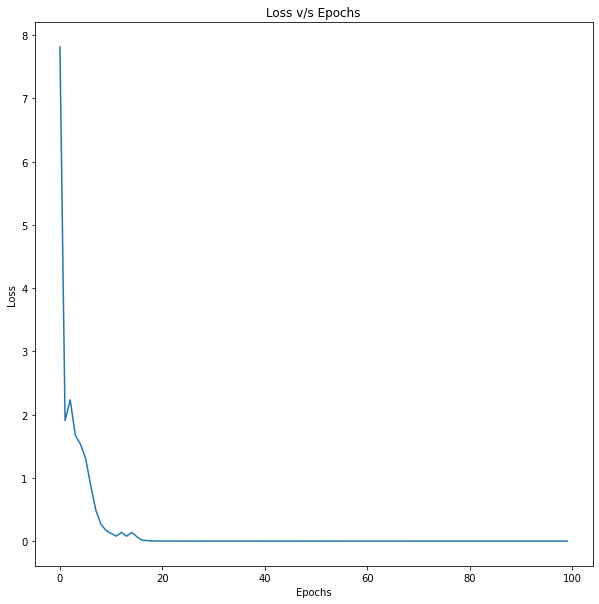

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 5. Testing

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images.float())
        
    _, predicted = torch.max(outputs.data, 1)
        
    total += 1
        
    correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (
    100 * correct / total))

Accuracy of test images: 81 %
